In [1]:
path_full_summarized_table = "../results/2023-05-24/00_processed/main/aurocs.tsv.gz"
path_config_viz = "../config/visualization.yaml"
path_output_dir = "./input_modalities.seq_struct.separate_prismnet_ideeps/"
export = True


# Forewords

Exploration of the differences in performance of models using sequence only as an input feature
and models using both sequence and structure.


Steps : 
- for each method + dataset + negative set: rank the auROCs.
- for each dataset + negative set: calculate the average rank per model
- plot the avg_rank_seq vs avg_rank_seq+struct ; spot those which show large deviation.
- check how these behave in the difference of auroc between neg1 and neg2.

# Imports and definitions

In [2]:
import os
import sys
from pathlib import Path

import pandas as pd
import polars as pl
import numpy as np
import yaml
import scipy.stats

from dotmap import DotMap


path = "../code/"
if not str(path) in sys.path:
    sys.path.insert(0, str(path))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from plotting_config import *

%run "../code/plotting_config.py"
%run "../code/figure_layouts.py"

/home/l10n/projects/hzm/Benchmark-RBP/analyses/code/figure_layouts.py:99: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


# Set-up

In [3]:
if export:
    if not Path(path_output_dir).exists():
        Path(path_output_dir).mkdir(parents=True, exist_ok=True)

# Load 

## Data 

In [4]:
full_summarized_table = pd.read_csv(
    path_full_summarized_table, sep="\t", header=0, index_col=None
)


## Config

In [5]:
with open(path_config_viz, "r") as in_f:
    config_viz = yaml.load(in_f, Loader=yaml.SafeLoader)

DATASETS_COLORS = config_viz["datasets"]["colors"]
DATASETS_dotshape = config_viz["datasets"]["shape"]
arch_colors = config_viz["methods"]["colors"]

In [6]:
sequence_only = [
    "Pysster-101",  # Pysster-101 is closer to the perf of other methods; using it should remove the input-length favorable bias.
    "DeepCLIP",
    "DeepRAM",
    # BERT-RBP, # Excluded given the poor results.
]
sequence_structure = ["PRISMNet", "iDeepS"]

map_method_to_inputfeat = {
    **{k: "seq" for k in sequence_only},
    **{k: "seq+struct" for k in sequence_structure},
}


In [7]:
# We will look at the top 10% models with greater auROC from seq+struct compared to seq-only
QUANTILE_THRESHOLD = 0.9


# Prepare and explore tables

## Prepare

In [8]:
def get_data_prismnet():
    tmp_inputfeat = (
        full_summarized_table.loc[
            lambda df: df["arch"].isin(
                sequence_only
                + [
                    "PRISMNet",
                ]
            ),
            :,
        ]
        .copy()
        .assign(arch_inputtype=lambda df: df["arch"].map(map_method_to_inputfeat.get))
    )

    tmp_inputfeat_n1 = tmp_inputfeat.loc[
        lambda df: df["model_negativeset"] == "negative-1", :
    ]
    tmp_inputfeat_n2 = tmp_inputfeat.loc[
        lambda df: df["model_negativeset"] == "negative-2", :
    ]
    # ALTERNATIVE : DIRECTLY WORK WITH AUROCs
    # The "rank" approach is difficult to grasp ; check if results are really different when taking
    # the average auROC.

    tmp_inputfeat_n1_piv_ALT = tmp_inputfeat_n1.pivot_table(
        index=["dataset", "RBP_dataset"],
        columns=["arch_inputtype"],
        values="auroc",
        aggfunc=np.mean,
    ).reset_index()

    tmp_inputfeat_n1_piv_ALT["delta"] = (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    )

    tmp_inputfeat_n1_piv_ALT["is_top_decile"] = (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    ) > (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    ).quantile(
        QUANTILE_THRESHOLD
    )

    tmp_inputfeat_n2_piv_ALT = tmp_inputfeat_n2.pivot_table(
        index=["dataset", "RBP_dataset"],
        columns=["arch_inputtype"],
        values="auroc",
        aggfunc=np.mean,
    ).reset_index()

    tmp_inputfeat_n2_piv_ALT["delta"] = (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    )

    tmp_inputfeat_n2_piv_ALT["is_top_decile"] = (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    ) > (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    ).quantile(
        QUANTILE_THRESHOLD
    )

    tmp_inputfeat_n2_piv_ALT["is_top_decile_n1"] = (
        tmp_inputfeat_n2_piv_ALT["RBP_dataset"]
        .isin(
            tmp_inputfeat_n1_piv_ALT.loc[
                tmp_inputfeat_n1_piv_ALT["is_top_decile"], "RBP_dataset"
            ].values
        )
        .values
    )

    return tmp_inputfeat_n1_piv_ALT, tmp_inputfeat_n2_piv_ALT


In [9]:
def get_data_ideeps():
    tmp_inputfeat = (
        full_summarized_table.loc[
            lambda df: df["arch"].isin(
                sequence_only
                + [
                    "iDeepS",
                ]
            ),
            :,
        ]
        .copy()
        .assign(arch_inputtype=lambda df: df["arch"].map(map_method_to_inputfeat.get))
    )

    tmp_inputfeat_n1 = tmp_inputfeat.loc[
        lambda df: df["model_negativeset"] == "negative-1", :
    ]
    tmp_inputfeat_n2 = tmp_inputfeat.loc[
        lambda df: df["model_negativeset"] == "negative-2", :
    ]
    # ALTERNATIVE : DIRECTLY WORK WITH AUROCs
    # The "rank" approach is difficult to grasp ; check if results are really different when taking
    # the average auROC.

    tmp_inputfeat_n1_piv_ALT = tmp_inputfeat_n1.pivot_table(
        index=["dataset", "RBP_dataset"],
        columns=["arch_inputtype"],
        values="auroc",
        aggfunc=np.mean,
    ).reset_index()

    tmp_inputfeat_n1_piv_ALT["delta"] = (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    )

    tmp_inputfeat_n1_piv_ALT["is_top_decile"] = (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    ) > (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    ).quantile(
        QUANTILE_THRESHOLD
    )

    tmp_inputfeat_n2_piv_ALT = tmp_inputfeat_n2.pivot_table(
        index=["dataset", "RBP_dataset"],
        columns=["arch_inputtype"],
        values="auroc",
        aggfunc=np.mean,
    ).reset_index()

    tmp_inputfeat_n2_piv_ALT["delta"] = (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    )

    tmp_inputfeat_n2_piv_ALT["is_top_decile"] = (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    ) > (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    ).quantile(
        QUANTILE_THRESHOLD
    )

    tmp_inputfeat_n2_piv_ALT["is_top_decile_n1"] = (
        tmp_inputfeat_n2_piv_ALT["RBP_dataset"]
        .isin(
            tmp_inputfeat_n1_piv_ALT.loc[
                tmp_inputfeat_n1_piv_ALT["is_top_decile"], "RBP_dataset"
            ].values
        )
        .values
    )

    return tmp_inputfeat_n1_piv_ALT, tmp_inputfeat_n2_piv_ALT


In [10]:
(ideeps_tmp_inputfeat_n1_piv_ALT, ideeps_tmp_inputfeat_n2_piv_ALT) = get_data_ideeps()
(
    prismnet_tmp_inputfeat_n1_piv_ALT,
    prismnet_tmp_inputfeat_n2_piv_ALT,
) = get_data_prismnet()


## Explore 

### Number of models, models with largest delta auROCs

In [11]:
print(
    ideeps_tmp_inputfeat_n1_piv_ALT.shape[0], prismnet_tmp_inputfeat_n1_piv_ALT.shape[0]
)


302 302


In [12]:
ideeps_rbps = set(
    ideeps_tmp_inputfeat_n1_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)
prismnet_rbps = set(
    prismnet_tmp_inputfeat_n1_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)


In [13]:
print(len(prismnet_rbps))
print(len(ideeps_rbps))


31
31


In [20]:
print(
    (
        "Number of models in the top10% of delta(auROC_seq+struct,auROC_seq)\n "
        "found in both `PrismNet vs seq-only` and `iDeepS vs seq-only` :"
        f"{len(prismnet_rbps & ideeps_rbps)}"
    )
)


Number of models in the top10% of delta(auROC_seq+struct,auROC_seq)
 found in both `PrismNet vs seq-only` and `iDeepS vs seq-only` :13


For paper: selected "EWSR1", "PUS1", "CAPRIN1".

In [19]:
display(prismnet_rbps & ideeps_rbps)


{'ABCF1_K562',
 'AKAP1_K562',
 'Ago2_UNKNOWN_HITSCLIP_4',
 'CAPRIN1_HEK293_PARCLIP',
 'CPEB4_K562',
 'DDX55_K562',
 'DICER1_HEK293_PARCLIP',
 'EWSR1_HEK293_PARCLIP',
 'G45_HEK293_PARCLIP',
 'NOLC1_K562',
 'PUS1_K562',
 'SUPV3L1_K562',
 'ZC3H11A_K562'}

In [21]:
prismnet_tmp_inputfeat_n1_piv_ALT.loc[
    lambda df: df["RBP_dataset"].isin(prismnet_rbps & ideeps_rbps), :
].sort_values(by="delta", ascending=False)


arch_inputtype,dataset,RBP_dataset,seq,seq+struct,delta,is_top_decile
137,ENCODE,PUS1_K562,0.683946,0.821449,0.137502,True
30,ENCODE,DDX55_K562,0.811865,0.931897,0.120032,True
2,ENCODE,ABCF1_K562,0.811491,0.930180,0.118689,True
6,ENCODE,AKAP1_K562,0.763634,0.880795,0.117160,True
180,ENCODE,SUPV3L1_K562,0.765513,0.880692,0.115179,True
229,Mukherjee-PAR-CLIP,DICER1_HEK293_PARCLIP,0.733363,0.840387,0.107024,True
117,ENCODE,NOLC1_K562,0.769646,0.870835,0.101190,True
244,Mukherjee-PAR-CLIP,G45_HEK293_PARCLIP,0.771970,0.864893,0.092923,True
217,ENCODE,ZC3H11A_K562,0.765082,0.855362,0.090280,True
275,iONMF,Ago2_UNKNOWN_HITSCLIP_4,0.811873,0.900852,0.088979,True


In [22]:
ideeps_tmp_inputfeat_n1_piv_ALT.loc[
    lambda df: df["RBP_dataset"].isin(prismnet_rbps & ideeps_rbps), :
].sort_values(by="delta", ascending=False)


arch_inputtype,dataset,RBP_dataset,seq,seq+struct,delta,is_top_decile
236,Mukherjee-PAR-CLIP,EWSR1_HEK293_PARCLIP,0.833197,0.951273,0.118076,True
226,Mukherjee-PAR-CLIP,CAPRIN1_HEK293_PARCLIP,0.772725,0.868386,0.095661,True
137,ENCODE,PUS1_K562,0.683946,0.761681,0.077735,True
244,Mukherjee-PAR-CLIP,G45_HEK293_PARCLIP,0.771970,0.847299,0.075329,True
275,iONMF,Ago2_UNKNOWN_HITSCLIP_4,0.811873,0.880279,0.068406,True
229,Mukherjee-PAR-CLIP,DICER1_HEK293_PARCLIP,0.733363,0.794396,0.061033,True
6,ENCODE,AKAP1_K562,0.763634,0.813621,0.049986,True
117,ENCODE,NOLC1_K562,0.769646,0.814083,0.044437,True
180,ENCODE,SUPV3L1_K562,0.765513,0.809689,0.044175,True
30,ENCODE,DDX55_K562,0.811865,0.855606,0.043742,True


## Further exploration

### Q: are similar RBPs picked-up with both tools?

In [23]:
ideeps_rbps_n1 = set(
    ideeps_tmp_inputfeat_n1_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)
prismnet_rbps_n1 = set(
    prismnet_tmp_inputfeat_n1_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)
print(len(prismnet_rbps_n1 & ideeps_rbps_n1))


13


- In the negative-1 setting, we did see for both iDeepS and PrismNet a subset of RBP_CT_DATASET showing a great difference in performance when compared to the average seq-only perf.
- For illustration, the arbitrary top 10% of models was identified for each, corresponding to 31 models.
- We see here that 13 of these are in common.

To test this, in R: 

```
phyper(13, 31, 302-31, 31, lower.tail = F)
```

yields `0.00000005906184`

with `phyper(q,m,n,k)` where we are testing a "mark-recapture"-like situation,
i.e. from resampling `k` elements, we observe `q` elements "marked", from a set
of `m` marked elements mixed with a set of `n` unmarked elements.

In [24]:
1 - scipy.stats.hypergeom.cdf(k=13, M=302, n=31, N=31)


5.9061838642016085e-08

In [25]:
dict_hypergeom_test = dict(
    k=len(prismnet_rbps_n1 & ideeps_rbps_n1),
    M=ideeps_tmp_inputfeat_n1_piv_ALT.shape[0],
    n=ideeps_tmp_inputfeat_n1_piv_ALT["is_top_decile"].sum(),
    N=prismnet_tmp_inputfeat_n1_piv_ALT["is_top_decile"].sum(),
)
display(dict_hypergeom_test)
(1 - scipy.stats.hypergeom.cdf(**dict_hypergeom_test))


{'k': 13, 'M': 302, 'n': 31, 'N': 31}

5.9061838642016085e-08

In [26]:
ideeps_rbps_n2 = set(
    ideeps_tmp_inputfeat_n2_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)
prismnet_rbps_n2 = set(
    prismnet_tmp_inputfeat_n2_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)
print(len(prismnet_rbps_n2 & ideeps_rbps_n2))


8


In [27]:
dict_hypergeom_test = dict(
    k=len(prismnet_rbps_n2 & ideeps_rbps_n2),
    M=ideeps_tmp_inputfeat_n2_piv_ALT.shape[0],
    n=ideeps_tmp_inputfeat_n2_piv_ALT["is_top_decile"].sum(),
    N=prismnet_tmp_inputfeat_n2_piv_ALT["is_top_decile"].sum(),
)
display(dict_hypergeom_test)
(1 - scipy.stats.hypergeom.cdf(**dict_hypergeom_test))


{'k': 8, 'M': 302, 'n': 31, 'N': 31}

0.0016423910249667717

### Q: for RBPs in common between datasets, are their rank in the delta-auROC comparable?

e.g. EWSR1: is in ENCODE (EWSR1_K562), PAR-CLIP (EWSR1_Hek293_PARCLIP), and iONMF.

⇒ for each dataset, is the associated model showing a greater rank than randomly
sampled models?


⇒ for iDeepS top 10% models, for the subset of which that are present in another dataset: are they showing greater ranks than random?


**not sensitive enough**: I will have very few RBPs left...

Suggestions:

- do the test of ranks at least on ENCODE models.
- correlation of ranks? (Kendall tau?, Spearman?)
- ???


In [28]:
# Illustration : EWSR1 is an RBP with models trained from all three datasets.
ideeps_tmp_inputfeat_n1_piv_ALT.loc[
    lambda df: df["RBP_dataset"].str.contains("EWSR1"), :
]


arch_inputtype,dataset,RBP_dataset,seq,seq+struct,delta,is_top_decile
47,ENCODE,EWSR1_K562,0.944672,0.948074,0.003402,False
236,Mukherjee-PAR-CLIP,EWSR1_HEK293_PARCLIP,0.833197,0.951273,0.118076,True
280,iONMF,EWSR1_UNKNOWN_PARCLIP_12,0.892376,0.893182,0.000806,False


#### Numbers of RBPs with more than one model

In [29]:
rbps = [
    rbp_ct_dataset.split("_")[0]
    for rbp_ct_dataset in full_summarized_table["RBP_dataset"].unique()
]
more_than_one_dataset = list(
    pd.Series(rbps).value_counts().loc[lambda v: v > 1].dropna().index.values
)


rbps_encode = [
    rbp_ct_dataset.split("_")[0]
    for rbp_ct_dataset in full_summarized_table["RBP_dataset"].unique()
    if (rbp_ct_dataset.endswith("K562") or rbp_ct_dataset.endswith("HepG2"))
]
rbps_both_ct_encode = list(
    pd.Series(rbps_encode).value_counts().loc[lambda v: v > 1].dropna().index.values
)

rbps_parclip = [
    rbp_ct_dataset.split("_")[0]
    for rbp_ct_dataset in full_summarized_table.loc[
        lambda df: df["dataset"].isin(["Mukherjee-PAR-CLIP"]), "RBP_dataset"
    ].unique()
]

rbps_parclip_encode = set(more_than_one_dataset) & set(rbps_parclip) & set(rbps_encode)


In [30]:
print(f"Number of RBPs with more than one datasets: {len(more_than_one_dataset)}")
print(
    f"Number of RBPs from ENCODE with both K562 and HepG2 models: {len(rbps_both_ct_encode)}"
)
print(f"Number of RBPs both in PAR-CLIP and ENCODE: {len(rbps_parclip_encode)}")


Number of RBPs with more than one datasets: 90
Number of RBPs from ENCODE with both K562 and HepG2 models: 73
Number of RBPs both in PAR-CLIP and ENCODE: 17


#### PAR-CLIP / ENCODE : agreement in delta auROC

#### Models from ENCODE HepG2 and K562 : agreement in delta auROC

In [34]:
def get_deltaauroc_agreement_encode(method, negative_set):
    if method not in ["ideeps", "prismnet"]:
        raise ValueError

    if negative_set not in ["negative-1", "negative-2"]:
        raise ValueError

    if method == "ideeps":
        if negative_set == "negative-1":
            source_table = ideeps_tmp_inputfeat_n1_piv_ALT
        else:
            source_table = ideeps_tmp_inputfeat_n2_piv_ALT
    else:
        if negative_set == "negative-1":
            source_table = prismnet_tmp_inputfeat_n1_piv_ALT
        else:
            source_table = prismnet_tmp_inputfeat_n2_piv_ALT

    source_table_w_ct_rbpname = []
    source_table_w_ct_rbpname.append(source_table)

    tmp = source_table["RBP_dataset"].str.split("_", expand=True).iloc[:, [0, 1]]
    tmp.columns = ['rbp_name','ct']
    source_table_w_ct_rbpname.append(tmp)

    source_table_w_ct_rbpname = pd.concat(source_table_w_ct_rbpname, axis=1)

    tmp_agreement_delta = source_table_w_ct_rbpname.loc[
        lambda df: (df["dataset"] == "ENCODE")
        & df["rbp_name"].isin(rbps_both_ct_encode),
        :,
    ].pivot_table(index="rbp_name", columns="ct", values="delta")

    return tmp_agreement_delta


tmp_agreement_encode_n1_delta_ideeps = get_deltaauroc_agreement_encode(
    "ideeps", "negative-1"
)
tmp_agreement_encode_n1_delta_prismnet = get_deltaauroc_agreement_encode(
    "prismnet", "negative-1"
)
tmp_agreement_encode_n2_delta_ideeps = get_deltaauroc_agreement_encode(
    "ideeps", "negative-2"
)
tmp_agreement_encode_n2_delta_prismnet = get_deltaauroc_agreement_encode(
    "prismnet", "negative-2"
)


In [35]:
tmp_agreement_encode_n1_delta_ideeps.corr(method="spearman")


ct,HepG2,K562
ct,,
HepG2,1.00000,0.28221
K562,0.28221,1.00000


In [38]:
def plot_agreement_encode(
    table_agreement_delta_encode,
    method: str,
    negative_set: str,
    ax=None,
):
    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        ax1 = fig.add_subplot(111)
    else:
        ax1 = ax

    sns.scatterplot(
        table_agreement_delta_encode,
        x="K562",
        y="HepG2",
        ax=ax1,
    )
    max_range = table_agreement_delta_encode.abs().max().max() * 1.1
    ax1.set_xlim(-max_range, max_range)
    ax1.set_ylim(-max_range, max_range)
    ax1.set_aspect("equal")

    spearmancorr = table_agreement_delta_encode.corr(method="spearman").iloc[0, 1]
    title = (
        f"delta-auROC {negative_set} ({method}, seq-only_avg),\n"
        f"for {len(rbps_both_ct_encode)} ENCODE RBPs found in both cell-lines\n"
        "(Spearman's rho = {:.3f})".format(spearmancorr)
    )

    ax1.set_title(title)
    plt.tight_layout()

    return ax1



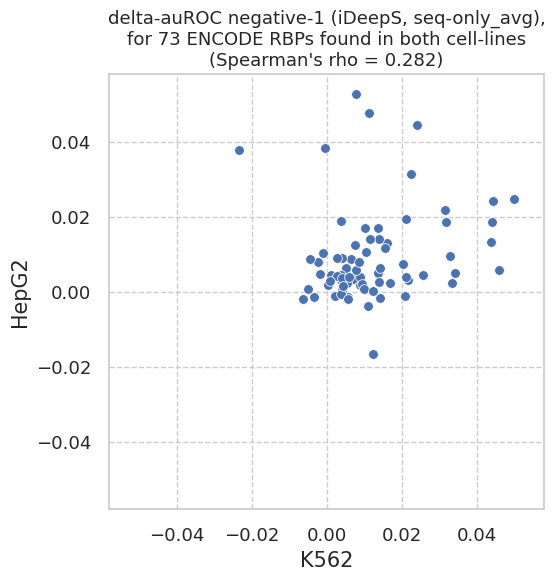

In [39]:
figure_name = "struct_vs_seq_only.ideeps.neg1.encode_ct"

if False:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

plot_agreement_encode(
    tmp_agreement_encode_n1_delta_ideeps,
    method="iDeepS",
    negative_set="negative-1",
    ax=None
)

if savefig_file:
    plt.savefig(savefig_file)

plt.show()


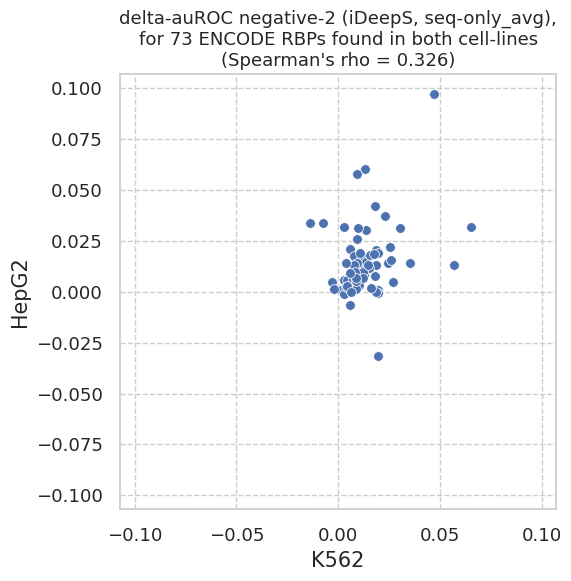

In [40]:
figure_name = "struct_vs_seq_only.ideeps.neg2.encode_ct"

if False:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

plot_agreement_encode(
    tmp_agreement_encode_n2_delta_ideeps,
    method="iDeepS",
    negative_set="negative-2",
    ax=None
)

if savefig_file:
    plt.savefig(savefig_file)

plt.show()



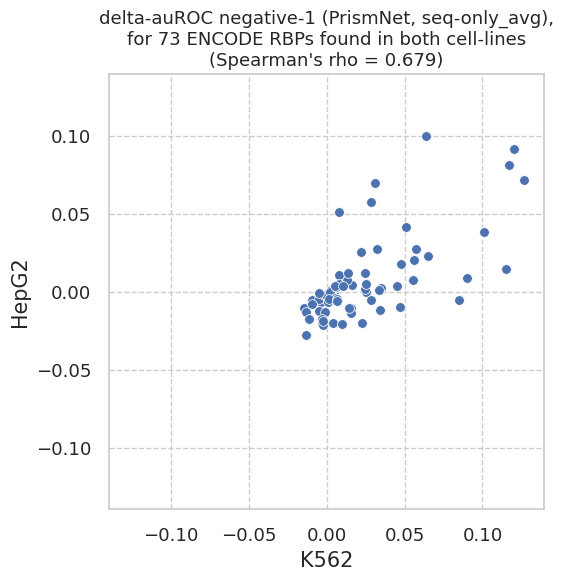

In [41]:
figure_name = "struct_vs_seq_only.prismnet.neg1.encode_ct"

if False:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

plot_agreement_encode(
    tmp_agreement_encode_n1_delta_prismnet,
    method="PrismNet",
    negative_set="negative-1",
    ax=None,
)


if savefig_file:
    plt.savefig(savefig_file)

plt.show()


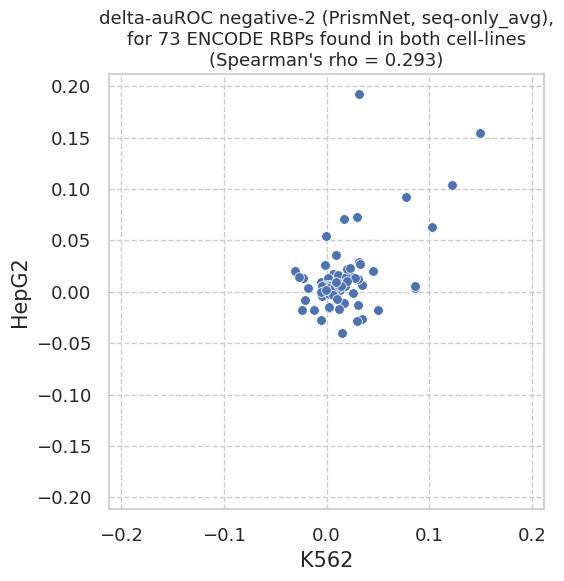

In [42]:
figure_name = "struct_vs_seq_only.prismnet.neg2.encode_ct"

if False:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None


plot_agreement_encode(
    tmp_agreement_encode_n2_delta_prismnet,
    method="PrismNet",
    negative_set="negative-2",
    ax=None,
)

if savefig_file:
    plt.savefig(savefig_file)

plt.show()


### Q: structure-sensitive RBPs : are they consistent across datasets/cell types

- A subset of RBPs does show a contribution of structure even in the negative-2 setting. Very pronounced for PrismNet (see plot down in the notebook).

- Are the associated RBPs explored in multiple cell-types / protocols? Is the effect
consistent?

#### iDeepS

In [43]:
tmp_ideeps_struct_n2 = ideeps_tmp_inputfeat_n2_piv_ALT.copy()
tmp_ideeps_struct_n2["is_top_decile"] = tmp_ideeps_struct_n2[
    "delta"
] > tmp_ideeps_struct_n2["delta"].quantile(QUANTILE_THRESHOLD)


In [44]:
ideeps_subset_consistently_structure_benefitting = tmp_ideeps_struct_n2.loc[
    lambda df: (df["is_top_decile"]) & (df["is_top_decile_n1"]), :
].sort_values(by="RBP_dataset", ascending=False)

display(ideeps_subset_consistently_structure_benefitting)


arch_inputtype,dataset,RBP_dataset,seq,seq+struct,delta,is_top_decile,is_top_decile_n1
209,ENCODE,XRCC6_HepG2,0.763526,0.805850,0.042324,True,True
268,Mukherjee-PAR-CLIP,UPF1_HEK293_PARCLIP,0.659395,0.709196,0.049801,True,True
266,Mukherjee-PAR-CLIP,TAF15_HEK293_PARCLIP,0.840137,0.887215,0.047079,True,True
180,ENCODE,SUPV3L1_K562,0.710404,0.767612,0.057209,True,True
244,Mukherjee-PAR-CLIP,G45_HEK293_PARCLIP,0.792862,0.834516,0.041654,True,True
226,Mukherjee-PAR-CLIP,CAPRIN1_HEK293_PARCLIP,0.761183,0.806208,0.045025,True,True


In [46]:
print(ideeps_subset_consistently_structure_benefitting.shape[0])


6


In [47]:
dict_hypergeom_test = dict(
    k=ideeps_subset_consistently_structure_benefitting.shape[0],
    M=ideeps_tmp_inputfeat_n2_piv_ALT.shape[0],
    n=ideeps_tmp_inputfeat_n2_piv_ALT["is_top_decile_n1"].sum(),
    N=ideeps_tmp_inputfeat_n2_piv_ALT["is_top_decile"].sum(),
)

display(dict_hypergeom_test)
display((1 - scipy.stats.hypergeom.cdf(**dict_hypergeom_test)))


{'k': 6, 'M': 302, 'n': 31, 'N': 31}

0.02680124371799919

#### PrismNet

In [48]:
tmp_prismnet_struct_n2 = prismnet_tmp_inputfeat_n2_piv_ALT.copy()
tmp_prismnet_struct_n2["is_top_decile"] = tmp_prismnet_struct_n2[
    "delta"
] > tmp_prismnet_struct_n2["delta"].quantile(QUANTILE_THRESHOLD)


In [49]:
prismnet_subset_consistently_structure_benefitting = tmp_prismnet_struct_n2.loc[
    lambda df: (df["is_top_decile"]) & (df["is_top_decile_n1"]), :
].sort_values(by="RBP_dataset", ascending=False)

display(prismnet_subset_consistently_structure_benefitting)


arch_inputtype,dataset,RBP_dataset,seq,seq+struct,delta,is_top_decile,is_top_decile_n1
218,ENCODE,ZC3H8_K562,0.659473,0.736001,0.076528,True,True
200,ENCODE,UPF1_K562,0.732386,0.854118,0.121732,True,True
199,ENCODE,UPF1_HepG2,0.754238,0.857766,0.103528,True,True
180,ENCODE,SUPV3L1_K562,0.710404,0.796817,0.086413,True,True
121,ENCODE,PABPC4_K562,0.705461,0.853262,0.147801,True,True
98,ENCODE,LARP4_HepG2,0.635173,0.827773,0.192600,True,True
66,ENCODE,GNL3_K562,0.592475,0.671342,0.078867,True,True
30,ENCODE,DDX55_K562,0.668456,0.817482,0.149026,True,True
29,ENCODE,DDX55_HepG2,0.662662,0.817323,0.154661,True,True
8,ENCODE,APOBEC3C_K562,0.610052,0.819037,0.208984,True,True


In [50]:
print(prismnet_subset_consistently_structure_benefitting.shape[0])


13


In [51]:
dict_hypergeom_test = dict(
    k=prismnet_subset_consistently_structure_benefitting.shape[0],
    M=prismnet_tmp_inputfeat_n2_piv_ALT.shape[0],
    n=prismnet_tmp_inputfeat_n2_piv_ALT["is_top_decile_n1"].sum(),
    N=prismnet_tmp_inputfeat_n2_piv_ALT["is_top_decile"].sum(),
)

display(dict_hypergeom_test)
display((1 - scipy.stats.hypergeom.cdf(**dict_hypergeom_test)))


{'k': 13, 'M': 302, 'n': 31, 'N': 31}

5.9061838642016085e-08

So AKAP1, DDX55, and UPF1 are RBPs for which the consistent structure-sensitivity
is detectable from both the K562 and the HepG2 models.


Unclear how to test further??? 

### Testing difference in performance of the models 

From visualization (see main plots down the notebook):

- delta auROC(seq+struct, seq) is less pronounced in neg-2 than in neg-1
- This degradation is less pronounced for PrismNet than iDeepS

Tests : 

- delta-auROC_neg1 vs delta-auROC_neg2 for each method => two Wilcoxon signed rank tests (paired models)
- delta-auroc_neg2_prismnet vs delta-auROC_neg2_ideeps one sided => one WSR to check if indeed the deltas are greater in the PrismNet models.

In [52]:
tmp_test_ideeps_diff_neg1neg2 = pd.concat(
    [
        ideeps_tmp_inputfeat_n1_piv_ALT.set_index("RBP_dataset")["delta"].rename(
            "neg1"
        ),
        ideeps_tmp_inputfeat_n2_piv_ALT.set_index("RBP_dataset")["delta"].rename(
            "neg2"
        ),
    ],
    axis=1,
)

print(
    scipy.stats.wilcoxon(
        x=tmp_test_ideeps_diff_neg1neg2["neg1"],
        y=tmp_test_ideeps_diff_neg1neg2["neg2"],
    )
)


WilcoxonResult(statistic=18962.0, pvalue=0.00995507470644192)


In [53]:
tmp_test_prismnet_diff_neg1neg2 = pd.concat(
    [
        prismnet_tmp_inputfeat_n1_piv_ALT.set_index("RBP_dataset")["delta"].rename(
            "neg1"
        ),
        prismnet_tmp_inputfeat_n2_piv_ALT.set_index("RBP_dataset")["delta"].rename(
            "neg2"
        ),
    ],
    axis=1,
)

print(
    scipy.stats.wilcoxon(
        x=tmp_test_prismnet_diff_neg1neg2["neg1"],
        y=tmp_test_prismnet_diff_neg1neg2["neg2"],
    )
)


WilcoxonResult(statistic=17356.0, pvalue=0.0002781869507946451)


In [54]:
tmp_test_neg2_diff_prismnet_ideeps = pd.concat(
    [
        ideeps_tmp_inputfeat_n2_piv_ALT.set_index("RBP_dataset")["delta"].rename(
            "ideeps"
        ),
        prismnet_tmp_inputfeat_n2_piv_ALT.set_index("RBP_dataset")["delta"].rename(
            "prismnet"
        ),
    ],
    axis=1,
)

print(
    scipy.stats.wilcoxon(
        x=tmp_test_neg2_diff_prismnet_ideeps["ideeps"],
        y=tmp_test_neg2_diff_prismnet_ideeps["prismnet"],
        alternative="greater",
    )
)


WilcoxonResult(statistic=28827.0, pvalue=4.4656424658456254e-05)


## Main Plots

### iDeepS

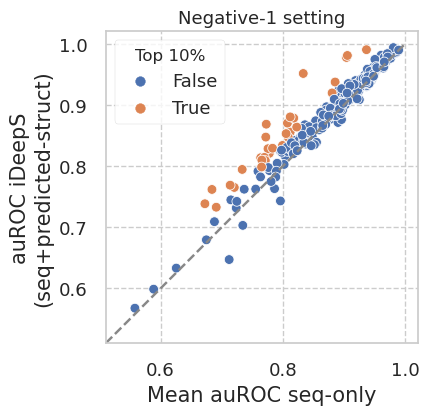

In [57]:
panel_name = "m"

figure_name = "scatterplot_auroc_seqstruct_vs_seqonly.ideeps.neg1"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None


fig = plt.figure(figsize=[v * 3 for v in FIG3_PANEL_SIZES["f"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)


sns.scatterplot(
    data=ideeps_tmp_inputfeat_n1_piv_ALT,
    x="seq",
    y="seq+struct",
    hue="is_top_decile",
    ax=ax1,
)
ax1.set_title("Negative-1 setting")
ax1.set_ylabel("auROC iDeepS\n(seq+predicted-struct)")
ax1.set_xlabel("Mean auROC seq-only")

ax1.legend_.set_title("Top 10%")

ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")


# Fit average and plot std
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)

ax1.set_aspect("equal")

ax1.set_xlim(0.51, 1.02)
ax1.set_ylim(0.51, 1.02)

fig.subplots_adjust(left=0.23, bottom=0.15)

plt.tight_layout


if savefig_file:
    my_savefig(savefig_file)


plt.show()


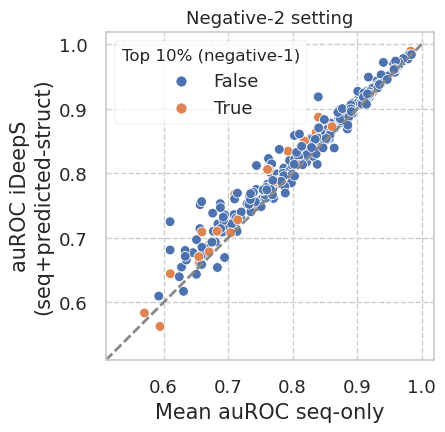

In [58]:
panel_name = "n"

figure_name = "scatterplot_auroc_seqstruct_vs_seqonly.ideeps.neg2"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None


fig = plt.figure(figsize=[v * 3 for v in FIG3_PANEL_SIZES["f"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=ideeps_tmp_inputfeat_n2_piv_ALT,
    x="seq",
    y="seq+struct",
    hue="is_top_decile_n1",
    ax=ax1,
)

ax1.set_title("Negative-2 setting")
ax1.set_ylabel("auROC iDeepS\n(seq+predicted-struct)")
ax1.set_xlabel("Mean auROC seq-only")

ax1.legend_.set_title("Top 10% (negative-1)")
ax1.legend_.set_title("Top 10% (negative-1)")
ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")
ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")

# Fit average and plot std
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)
ax1.set_aspect("equal")
ax1.set_aspect("equal")
ax1.set_xlim(0.51, 1.02)
ax1.set_xlim(0.51, 1.02)
ax1.set_ylim(0.51, 1.02)
fig.subplots_adjust(left=0.23, bottom=0.15)

plt.tight_layout()

if savefig_file:
    my_savefig(savefig_file)


plt.show()


### PrismNet

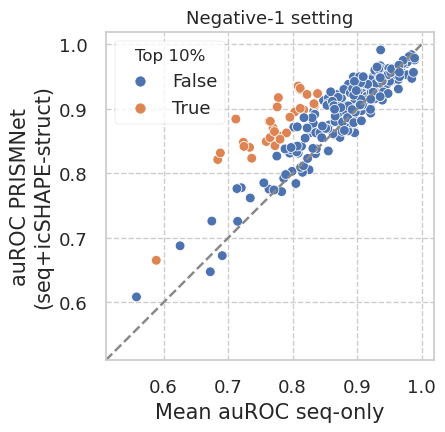

In [55]:
panel_name = "o"

figure_name = "scatterplot_auroc_seqstruct_vs_seqonly.prismnet.neg1"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

fig = plt.figure(figsize=[v * 3 for v in FIG3_PANEL_SIZES["f"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)


sns.scatterplot(
    data=prismnet_tmp_inputfeat_n1_piv_ALT,
    x="seq",
    y="seq+struct",
    hue="is_top_decile",
    ax=ax1,
)
ax1.set_title("Negative-1 setting")
ax1.set_ylabel("auROC PRISMNet\n(seq+icSHAPE-struct)")
ax1.set_xlabel("Mean auROC seq-only")

ax1.legend_.set_title("Top 10%")

ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")


# Fit average and plot std
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)

ax1.set_aspect("equal")

ax1.set_xlim(0.51, 1.02)
ax1.set_ylim(0.51, 1.02)

fig.subplots_adjust(left=0.23, bottom=0.15)
plt.tight_layout()


if savefig_file:
    my_savefig(savefig_file)


plt.show()


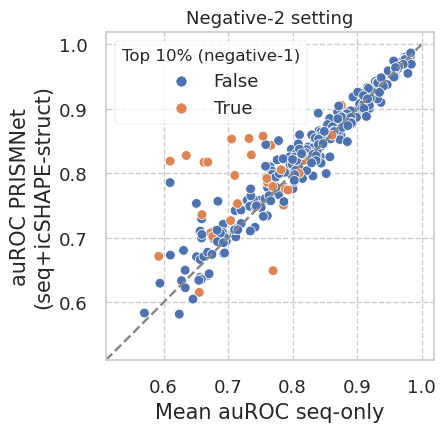

In [56]:
# PRISMNET
panel_name = "p"

figure_name = "scatterplot_auroc_seqstruct_vs_seqonly.prismnet.neg2"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None


fig = plt.figure(figsize=[v * 3 for v in FIG3_PANEL_SIZES["f"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=prismnet_tmp_inputfeat_n2_piv_ALT,
    x="seq",
    y="seq+struct",
    hue="is_top_decile_n1",
    ax=ax1,
)

ax1.set_title("Negative-2 setting")
ax1.set_ylabel("auROC PRISMNet\n(seq+icSHAPE-struct)")
ax1.set_xlabel("Mean auROC seq-only")

ax1.legend_.set_title("Top 10% (negative-1)")

ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")

# Fit average and plot std
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)

ax1.set_aspect("equal")

ax1.set_xlim(0.51, 1.02)
ax1.set_ylim(0.51, 1.02)

fig.subplots_adjust(left=0.23, bottom=0.15)
plt.tight_layout()

if savefig_file:
    my_savefig(savefig_file, ext_list=["png", "svg", "pdf"])


plt.show()
